In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time
import io
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


def initialization(seed=42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.current_device())

True
1
NVIDIA GeForce GTX 1050 Ti
0


<img src="../images/ObjectDetection/4-2.jpg">

> Ren S, He K, Girshick R, et al. Faster r-cnn: Towards real-time object detection with region proposal networks[J]. Advances in neural information processing systems, 2015, 28.

# 论文概述

`Faster R-CNN`是作者Ross Girshick：继`Fast R-CNN`后的又一力作。同样使用`VGG16`作为网络的backbone，推理速度在GPU上达到5fps(包括候选区域的生成)，准确率也有进一步的提升。在2015年的LSVRC以及COCO竞赛中获得多个项目的第一名。

该网络的主要贡献在于：
- 性能优越：`Faster RCNN`通过两阶网络与`RPN`，实现了精度较高的物体检测性能。
- 两阶网络：相比起其他一阶网络，两阶更为精准，尤其是针对高精度、多尺度以及小物体问题上，两阶网络优势更为明显。
- 通用性与鲁棒性：`Faster RCNN`在多个数据集及物体任务上效果都很好，对于个人的数据集，往往Fine-tune（微调）后就能达到较好的效果。
- 可优化点很多：`Faster RCNN`的整个算法框架中可以进行优化的点很多，提供了广阔的算法优化空间。
- 代码全面：各大深度学习框架都有较好的`Faster RCNN`源码实现，使用方便。

<img src="../images/ObjectDetection/4-4.jpg" width=400>

---

## 算法步骤

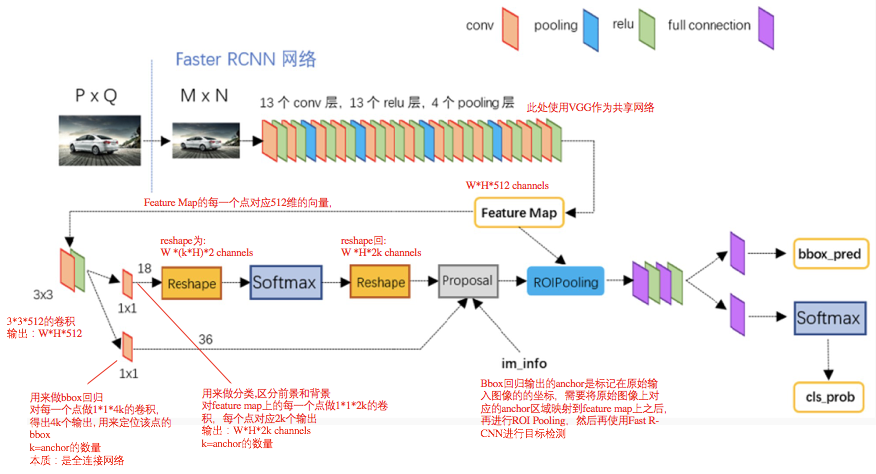

###  Conv layers

<span class="mark">Conv layers</span>:**将图像输入网络得到相应的特征图**
> `Fast R-CNN`虽然提出了`ROI Pooling`的特征提取方式，很好地解决了传统`R-CNN`中将候选区域分别输入CNN网络中的弊端。但都是使用传统`Selective Search`搜索方式确定候选区域，训练和测试时消耗了大量时间在RP搜索上。

   论文中使用`VGG`/`ZFNet`作为基础网络。上图是基于`VGG16`进行绘制的.以`VGG16`为例:
    全卷积网络使用VGG16作为骨架网络, 共有13个conv层，13个relu层，4个pooling层。
   - 所有的conv层都是：`kernel_size=3，pad=1，stride=1`
        
   所有的卷积都做了扩边处理（ pad=1，即填充一圈0），导致原图变为 $(M+2)×(N+2)$大小，再做3x3卷积后输出$M×N$ 。正是这种设置，导致*Conv layers*中的conv层不改变输入和输出矩阵大小
<img src="../images/ObjectDetection/4-6.jpg" width=400>
     
   - 所有的pooling层都是：`kernel_size=2，pad=0，stride=2`
    
    每个经过pooling层的$M×N$矩阵，都会变为$(M/2)×(N/2)$大小。综上所述，在整个*Conv layers*中，conv和relu层不改变输入输出大小，只有pooling层使输出长宽都变为输入的1/2。
    

   经过卷积模块得到相应的特征图后，一个$M×N$（800×600）大小的输入图像就变为了$\left(\frac{M}{16}\right)×\left(\frac{N}{16}\right)$的特征图(由于包含了4个池化层,即$(\frac{1}{2})^4$).
    

### Region Proposal Networks

 <span class="mark">Region Proposal Networks</span>:**使用RPN结构生成候选框，将RPN生成的候选框投影到特征图上获得相应的特征矩阵**
> `Faster R-CNN`在`Fast R-CNN`的基础上，提出了`RPN`网络用来生成候选区域。通过网络共享将提取候选框与目标检测结合成一个整体进行训练，替换了`Fast R-CNN`中使用`Selective Search`进行提取候选框的方法，提高了测试过程的速度。
> <img src="../images/ObjectDetection/4-7.jpg" width=600> 以看到`RPN`网络实际分为2条线:
>    - 上面一条通过`softmax`分类anchors获得正负分类
>    - 下面一条用于计算对于anchors的bounding box regression偏移量，以获得精确的proposal。
>    - 最后的Proposal层则负责综合positive anchors和对应bounding box regression偏移量获取proposals，同时剔除太小和超出边界的proposals。其实整个网络到了Proposal Layer这里，就完成了相当于目标定位的功能。
>    - **总结: 生成anchors -> softmax分类器提取positvie anchors -> bbox reg回归positive anchors -> Proposal Layer生成proposals**

#### 生成anchors

> anchor的概念：其思想就是将特征图上的每一个点映射回原始输入图像上，在原始图像上以该点为中心生成不同尺寸、不同比例的候选框，作为RPN待分类的候选框.设为每个特征点生成$k$个anchor，若Feature Map大小为$W×H$，则该特征图共有$W×H×k$个anchor。

- `cls layer`：每一个特征点包括$k$个anchor，使用**2位来标记每个anchor是否包含目标的概率**。

- `reg layer`：每一个特征点对应$k$个anchor，使用**4位来表示每个anchor的bounding box**，`reg layer`对bounding box进行回归修正其边界。

- 对于特征图上的每个3x3的滑动窗口，计算出滑动窗口中心点对应原始图像上的中心点，获得一个512维度的向量,并计算出k个 anchor boxes(注意和proposal的差异)。
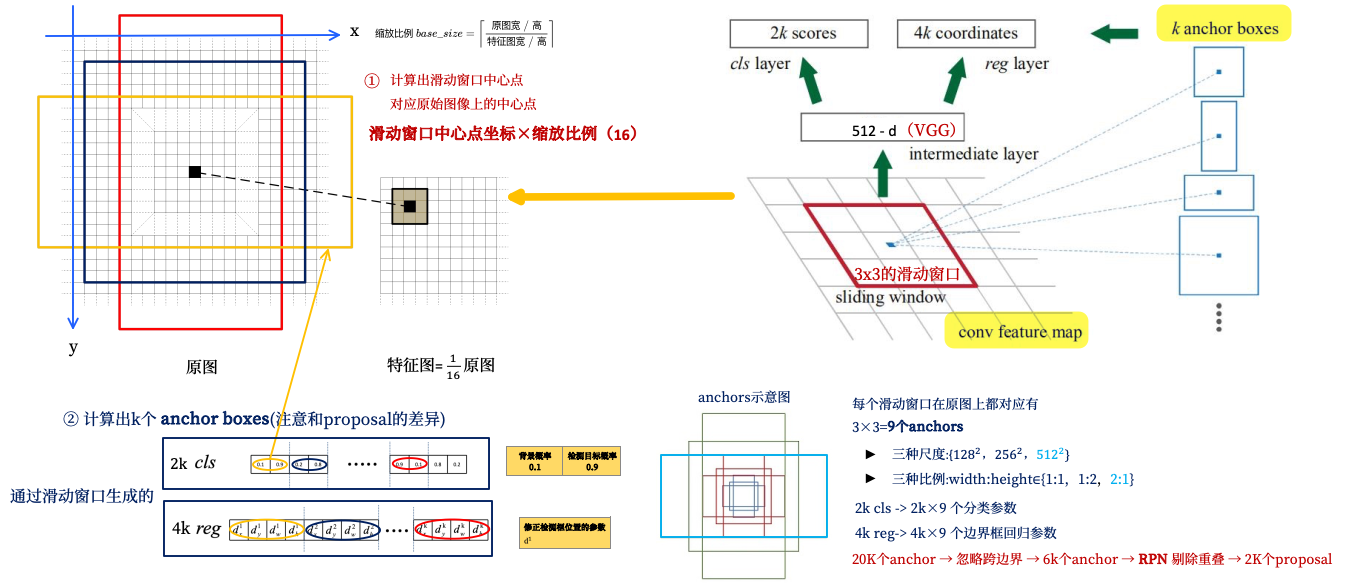    
> 感受野计算公式：$F (i) = [ F (i + 1) - 1] × Stride + Ksize$
>
> 对于ZF感受野：171 ; 对于VGG感受野：228. 
>
> 为什么可以预测比自己感受野尺度大的边界框?作者认为根据经验是可以实现的.


Q：使用anchor的好处是什么？

A：虽然也是使用滑动窗口思想，但是滑动窗口操作是在卷积层特征图上进行的，维度较原始图像降低了16x16倍（中间经过了4次2x2的pooling操作）；另外采用了9种anchor可以获得多尺度特征，对应了三种尺度和三种长宽比，加上后边接了边框回归，所以即便只使用这9种anchor外的窗口也能得到一个跟目标比较接近的region proposal。

- 对于一张1000x600x3的图像，**大约有60x40x9(20k)个anchor**，忽略跨越边界的anchor以后，剩下约6k个anchor。对于`RPN`生成的候选框之间存在大量重叠，基于候选框的cls得分，采用非极大值抑制，**IoU设为0.7**，这样**每张图片只剩2k个候选框proposal**。
- 全部anchors拿去训练太多了，训练程序会在合适的anchors中随机选取128个postive anchors+128个negative anchors进行训练
  - postive判定:（i）一个与GT的IoU大于0.7的候选框 或（ii）anchors与某个GT具有最高IoU(当没有一个候选框与GT的IoU大于0.7时)
  - negative判定:与所以GT的IoU都小于0.3的候选框
  - 对于非postive/negative的样本全部舍弃;跨越图像边界的anchor全部舍弃。

#### softmax判定positive与negative

一副$M×N$大小的矩阵送入`Faster RCNN`网络后，到`RPN`网络变为$(M/16)×(N/16)$，不妨设 $W=M/16$，$H=N/16$。

- `RPN网络`的上一条线是**通过`softmax`分类anchors获得正负样本(用来做分类，区分前景和背景**)
- 在进入reshape与softmax之前，对特征图上的每一个点做**1×1×2K的卷积**，每个点对应2K个输出(positive和negative), 因此经过该卷积的输出图像为$W×H×(9×2)$大小.
- 后面接softmax分类获得positive anchors，也就相当于初步提取了检测目标候选区域box.

> 在softmax前后都接一个reshape layer,是因为caffe实现时存储形式:其在caffe blob中的存储形式为`[1, 2x9, H, W]`。而在softmax分类时需要进行positive/negative二分类，所以reshape layer会将其变为`[1, 2, 9xH, W]`大小，即单独“腾空”出来一个维度以便softmax分类，之后再reshape回复原状.

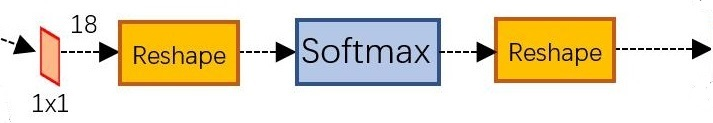

#### 对proposals进行bounding box regression

- `RPN网络`的下一条线**用于计算对于anchors的bounding box regression偏移量，以获得精确的proposal**
- 首先是对特征图上的每一个点做**1×1×4K的卷积**，每个点对应4K个输出(坐标回归参数), 因此经过该卷积的输出图像为$W×H×(9×4)$大小.

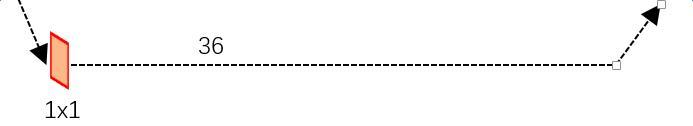

#### Proposal Layer

- `Proposal Layer`负责综合所有 $\left[d_x(A), d_y(A), d_w(A), d_h(A)\right]$ 变换量和positive anchors, 计算出精准的proposal, 送入后续`Rol Pooling Layer`。
- 输入: 分类器结果; 回归器偏移量; `im_info`.
- `im_info`:对于一副任意大小$P×Q$图像，**传入`Faster RCNN`前首先reshape**到固定$MxN$，`im_info=[M, N, scale_factor]`则保存了此次缩放的所有信息。然后经过`Conv Layers`，经过4次pooling变为$W×H=(M/16)×(N/16)$大小，其中feature_stride=16则保存了该信息，用于计算anchor偏移量。

<img src="../images/ObjectDetection/4-7.jpg" width=600> 

`Proposal Layer forward`按照以下顺序依次处理：

1. **生成anchors**，利用对$\left[d_x(A), d_y(A), d_w(A), d_h(A)\right]$所有的anchors做bbox regression**回归**（这里的anchors生成和训练时完全一致）
2. 按照输入的positive softmax scores由大到小**排序anchors**，**提取**前pre_nms_topN(e.g. 6000)个anchors，即提取修正位置后的positive anchors
3. 限定超出图像边界的positive anchors为图像边界，防止后续roi pooling时proposal超出图像边界
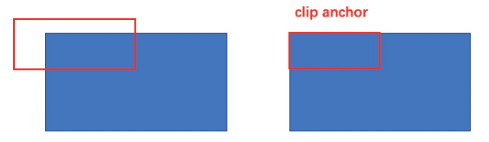
4. 剔除尺寸非常小的positive anchors
5. 对剩余的positive anchors进行NMS（nonmaximum suppression）
6. Proposal Layer有3个输入：positive和negative anchors分类器结果; im_info; 对应的bbox reg的结果.

输出proposal=$[x1, y1, x2, y2]$，注意，由于在第三步中将anchors映射回原图判断是否超出边界，所以这里输出的proposal是对应$M×N$输入图像尺度的，这点在后续网络中有用。另外我认为，严格意义上的检测应该到此就结束了，后续部分应该属于识别了。

### RoI pooling



3. 将每个特征矩阵通过ROI pooling层缩放到7x7大小的特征图， 接着将特征图展平通过一系列全连接层得到预测结果

## RPN 多任务损失

> **RPN Multi-task loss**
> $$
\begin{array}{r}
L\left(\left\{p_i\right\},\left\{t_i\right\}\right)=\frac{1}{N_{c l s}} \color{red}{\sum L_i L_{c l s}\left(p_i, p_i^*\right)} + \lambda \frac{1}{N_{\text {rea }}} \color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }.
\end{array}
$$
> 
>
>
> - $p_i$ 是表示第i个anchor预测为真实标签的概率
> - $p_i^*$ 当为正样本时为1，当为负样本时为0
> - $t_i$ 表示预测第i个anchorl的边界框回归参数
> - $t_i^*$ 表示第i个anchor)对应的GT Box的边界框回归参数
> - $N_{vls}$ 表示一个mini-batch中的所有样本数量256
> - $N_{reg}$ 表示anchor位置的个数（不是anchor个数）约2400

1. 分类损失:使用`Binary Cross Entropy Loss二值交叉熵损失`: 注意使用二值交叉熵损失这里是`cls layer` 只预测**k scores**,而不是2k scores.
$$\color{red}{\sum L_i L_{c l s}\left(p_i, p_i^*\right)}\\
L_{c l s}=-\left[p_i^* \log \left(p_i\right)+\left(1-p_i^*\right) \log \left(1-p_i\right)\right]
$$

    - $p_i$表示第$i$个anchor预测为目标的概率 
    - $p_i^*$当为正样本时为1，当为负样本时为0
    
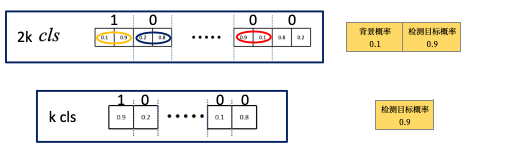

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
$$\color{blue} {\sum p_i^* L_{r e g}\left(t_i, t_i^*\right) }$$

\begin{aligned}
&L_{\text {loc }}\left(t_i, t_i^*\right)=\sum_{i} \operatorname{smooth}_{L_1}\left(t_i-t_i^*\right) \\
&t_i=\left[t_x, t_y, t_w, t_h\right] \quad t_i^*=\left[t_x^*, t_y^*, t_w^*, t_h^*\right] \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}

$$
\begin{aligned}
&t_x=\left(x-x_a\right) / w_a, t_y=\left(y-y_a\right) / h_a, \\
&t_w=\log \left(w / w_a\right), t_h=\log \left(h / h_a\right) \\
&t_x^*=\left(x^*-x_a\right) / w_a, t_y^*=\left(y^*-y_a\right) / h_a, \\
&t_w^*=\log \left(w^* / w_a\right), t_h^*=\log \left(h^* / h_a\right)
\end{aligned}
$$

## Fast R-CNN 多任务损失

> **Multi-task loss**
> $$
L\left(p, u, t^u, v\right)=L_{c l s}(p, u)+\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)
$$
> 
>
>
> - $p$ 是分类器预测的 softmax概率分布 $p=\left(p_0, \ldots, p_k\right)$
> - $u$ 对应目标真实类别标签
> - $t^u$ 对应边界框回归器预测的对应类别
> - $u$ 的回归参数 $\left(t_x^u, t_y^u, t_w^u, t_h^u\right)$
> - $v$ 对应真实目标的边界框回归参数 $\left(v_x, v_y, v_w, v_h\right)$
> > $$
\begin{aligned}
&v_x=\left(G_x-P_x\right) / P_w \\
&v_y=\left(G_y-P_y\right) / P_h \\
&v_w=\log \left(G_w / P_w\right)  \\
&v_h=\log \left(G_h / P_h\right)
\end{aligned}
$$

1. 分类损失:使用`Cross Entropy Loss交叉熵损失`
$$L_{c l s}(p, u)=-logp_u$$

2. 边界框回归损失:使用`Smooth 𝐿1损失函数`
$$\lambda[u \geq 1] L_{l o c}\left(t^u, v\right)$$

\begin{aligned}
&L_{\text {loc }}\left(t^u, v\right)=\sum_{i \in\{x, y, w, h\}} \operatorname{smooth}_{L_1}\left(t_i^u-v_i\right) \\
&\text { smooth }_{L_1}(x)= \begin{cases}0.5 x^2 & \text { if }|x|<1 \\
|x|-0.5 & \text { otherwise }\end{cases}
\end{aligned}

## Faster R-CNN训练

- **直接采用RPN Loss+ Fast R-CNN Loss的联合训练方法**


- 原论文中采用分别训练`RPN`以及`Fast R-CNN`的方法
    1. 利用ImageNet预训练分类模型初始化前置卷积网络层参数，并开始单独训练RPN网络参数；
    2. 固定`RPN`网络独有的卷积层以及全连接层参数，再利用 ImageNet预训练分类模型初始化前置卷积网络参数，并利用`RPN` 网络生成的目标建议框去训练`Fast RCNN`网络参数。
    3. 固定利用`Fast RCNN`训练好的前置卷积网络层参数，去微调`RPN` 网络独有的卷积层以及全连接层参数。
    4. 同样保持固定前置卷积网络层参数，去微调`Fast RCNN`网络的全连接层参数。最后`RPN`网络与`Fast RCNN`网络共享前置卷积网络层参数，构成一个统一网络。
